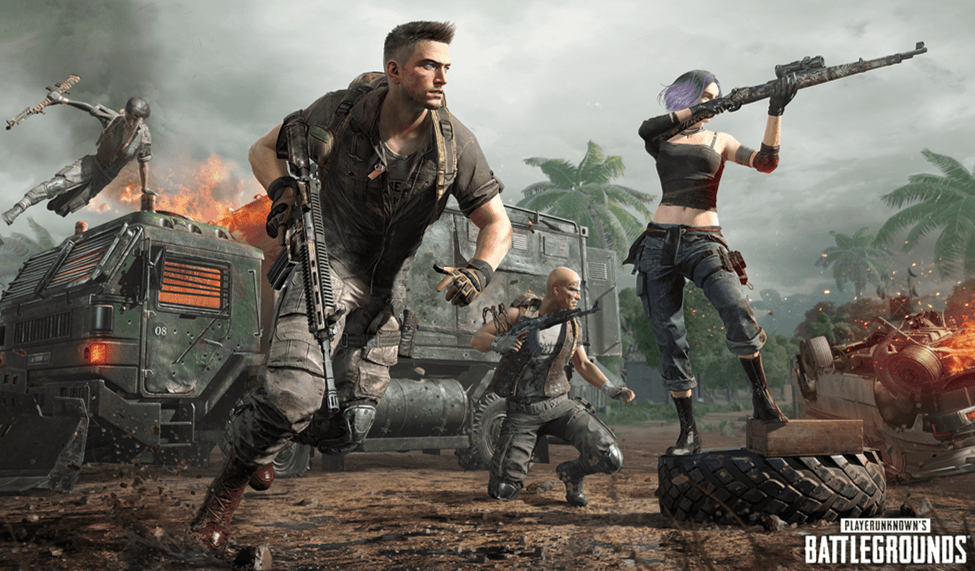

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Reading data

In [3]:
df = pd.read_csv("pubg.csv")

In [4]:
df.head()

Id         groupId         matchId  assists  boosts  \
0  7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1  eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2  1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3  4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4  315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   

   damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
0         0.00      0              0      0         60  ...        0   
1        91.47      0              0      0         57  ...        0   
2        68.00      0              0      0         47  ...        0   
3        32.90      0              0      0         75  ...        0   
4       100.00      0              0      0         45  ...        0   

   rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
0        0.0000          0          0.00          0               0   
1        0.0045          0         11.04          0               0   
2        0.0000          0          0.00          0               0   
3        0.0000          0          0.00          0               0   
4        0.0000          0          0.00          0               0   

   walkDistance  weaponsAcquired  winPoints  winPlacePerc  
0        244.80                1       1466        0.4444  
1       1434.00                5          0        0.6400  
2        161.80                2          0        0.7755  
3        202.70                3          0        0.1667  
4         49.75                2          0        0.1875  

[5 rows x 29 columns]

In [7]:
df.shape

(311056, 29)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

Data Description:

DBNOs – Number of enemy players knocked.

assists – Number of enemy players this player damaged that were killed by teammates.

boosts – Number of boost items used.

damageDealt – Total damage dealt. Note: Self-inflicted damage is subtracted.

headshotKills – Number of enemy players killed with headshots.

heals – Number of healing items used.

Id – Player’s ID.

killPlace – Ranking in match of number of enemy players killed.

killPoints – Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter. If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as "None.")

killStreaks – Max number of enemy players killed in a short amount of time.

kills – Number of enemy players killed.

longestKill – Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

matchDuration – Duration of match in seconds.

matchId – ID to identify match. There are no matches that are in both the training and testing set.

matchType – String identifying the game mode the data comes from. The standard modes are "solo", "duo", "squad", "solo-fpp", "duo-fpp", and "squad-fpp"; other modes are from events or custom matches.

rankPoints – Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of "None".

revives – Number of times this player revived teammates.

rideDistance – Total distance traveled in vehicles measured in meters.

roadKills – Number of kills while in a vehicle.

swimDistance – Total distance traveled by swimming measured in meters.

teamKills – Number of times this player killed a teammate.

vehicleDestroys – Number of vehicles destroyed.

walkDistance – Total distance traveled on foot measured in meters.

weaponsAcquired – Number of weapons picked up.

winPoints – Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters. If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as "None.")

groupId – ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

numGroups – Number of groups we have data for in the match.

maxPlace – Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

winPlacePerc – The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.


# Data Wrangling and Cleaning

Dealing with Null Values

In [6]:
df['winPlacePerc'].isnull().sum()

1

In [7]:
df[df['winPlacePerc'].isnull()]

Id         groupId         matchId  assists  boosts  \
2744604  f70c74418bb064  12dfbede33f92b  224a123c53e008        0       0   

         damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
2744604          0.0      0              0      0          1  ...        0   

         rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
2744604           0.0          0           0.0          0               0   

         walkDistance  weaponsAcquired  winPoints  winPlacePerc  
2744604           0.0                0          0           NaN  

[1 rows x 29 columns]

In [8]:
df = df.dropna(subset=['winPlacePerc'])

In [9]:
df['winPlacePerc'].isnull().sum()

0

Understanding Players distribution in a game

In [10]:
df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')

In [11]:
df

Id         groupId         matchId  assists  boosts  \
0        7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1        eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2        1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3        4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4        315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   
...                 ...             ...             ...      ...     ...   
4446961  afff7f652dbc10  d238e426f50de7  18492834ce5635        0       0   
4446962  f4197cf374e6c0  408cdb5c46b2ac  ee854b837376d9        0       1   
4446963  e1948b1295c88a  e26ac84bdf7cef  6d0cd12784f1ab        0       0   
4446964  cc032cdd73b7ac  c2223f35411394  c9c701d0ad758a        0       4   
4446965  0d8e7ed728b6fd  8c74f72fedf5ff  62a16aabcc095c        0       2   

         damageDealt  DBNOs  headshotKills  heals  killPlace  ...  \
0               0.00      0              0      0         60  ...   
1              91.47      0              0      0         57  ...   
2              68.00      0              0      0         47  ...   
3              32.90      0              0      0         75  ...   
4             100.00      0              0      0         45  ...   
...              ...    ...            ...    ...        ...  ...   
4446961         0.00      0              0      0         74  ...   
4446962        44.15      0              0      0         69  ...   
4446963        59.06      0              0      0         66  ...   
4446964       180.40      1              1      2         11  ...   
4446965       268.00      0              0      1         18  ...   

         rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
0              0.0000          0         0.000          0                0   
1              0.0045          0        11.040          0                0   
2              0.0000          0         0.000          0                0   
3              0.0000          0         0.000          0                0   
4              0.0000          0         0.000          0                0   
...               ...        ...           ...        ...              ...   
4446961     1292.0000          0         0.000          0                0   
4446962        0.0000          0         0.000          0                0   
4446963        0.0000          0         2.184          0                0   
4446964        0.0000          0         0.000          0                0   
4446965     1369.0000          0         0.000          0                0   

        walkDistance  weaponsAcquired  winPoints  winPlacePerc  playersJoined  
0             244.80                1       1466        0.4444             96  
1            1434.00                5          0        0.6400             91  
2             161.80                2          0        0.7755             98  
3             202.70                3          0        0.1667             91  
4              49.75                2          0        0.1875             97  
...              ...              ...        ...           ...            ...  
4446961      1019.00                3       1507        0.1786             94  
4446962        81.70                6          0        0.2935             93  
4446963       788.70                4          0        0.4815             98  
4446964      2748.00                8          0        0.8000             94  
4446965      1244.00                5          0        0.5464             98  

[4446965 rows x 30 columns]

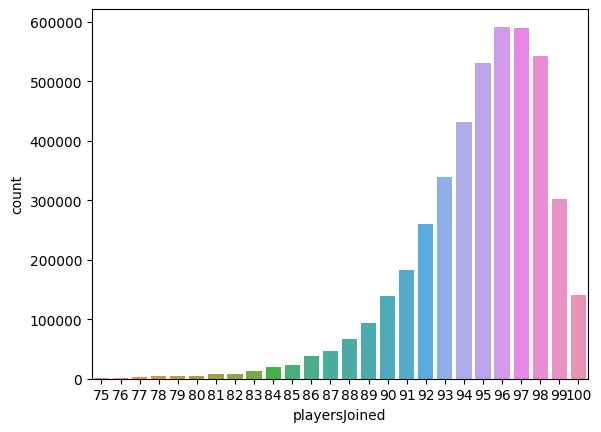

In [12]:
filtered_df = df[df['playersJoined'] >= 75]
sns.countplot(x='playersJoined', data=filtered_df)
plt.show()

# Analysing data

In [13]:
df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']
df['killswithoutMoving'] = (df['kills']>0) & (df['totalDistance'] ==0)

In [14]:
df[df['killswithoutMoving'] == True].shape

(1535, 32)

Dropping modders and hackers

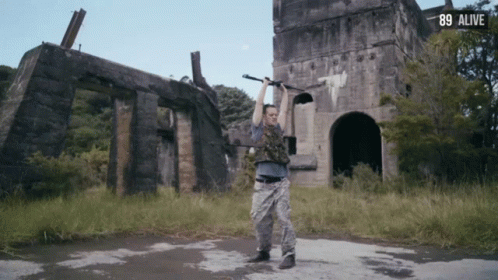

Dropping all the kills without moving

In [15]:
df.drop(df[df['killswithoutMoving'] == True].index, inplace = True)

Dropping road kills greater than 5

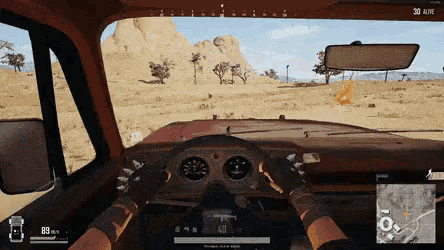

In [16]:
df[df['roadKills']>5].shape

(46, 32)

In [17]:
df.drop(df[df['roadKills']>5].index, inplace = True)

Analysing number of kills

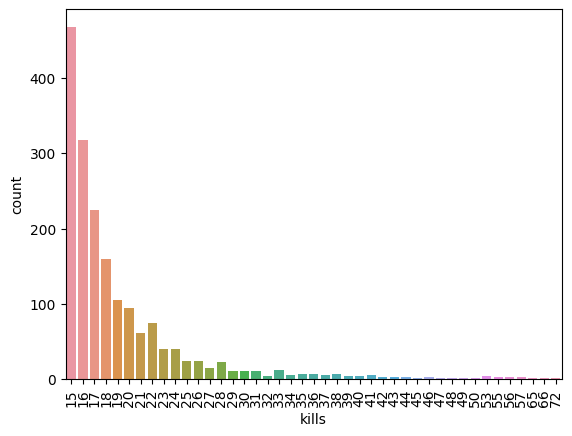

In [18]:
sns.countplot(x='kills', data=df[df['kills'] >= 15])
plt.xticks(rotation=90)
plt.show()

Dropping rows with kills greater than 25

In [22]:
df[df['kills']> 25].shape

(8, 32)

In [23]:
df.drop(df[df['kills']> 25].index, inplace = True)

Analysing Headshot rate

In [24]:
df['headshot_rate'] = df['headshotKills']/df['kills']


<ipython-input-25-2024965627>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['headshot_rate'], bins=20, kde=True, color='blue')


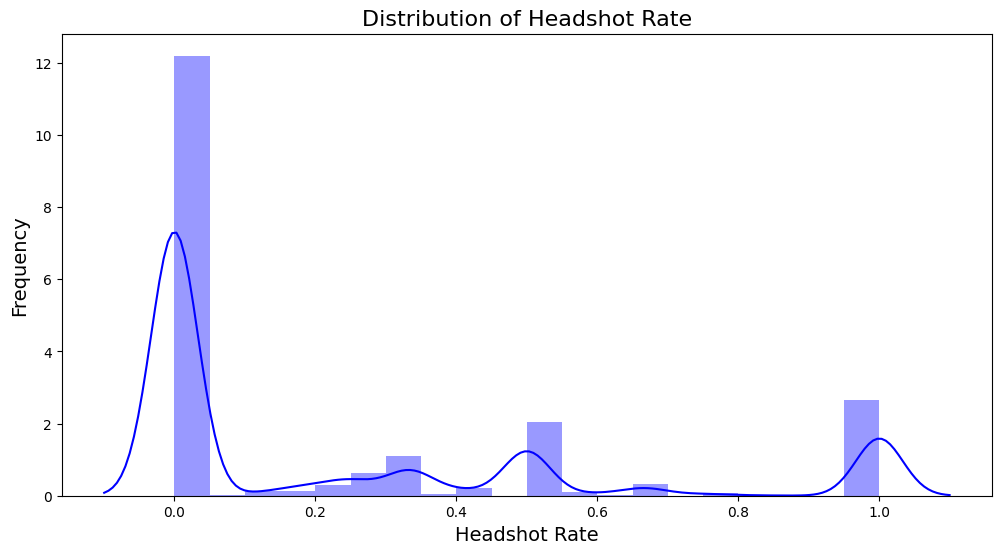

In [25]:
plt.figure(figsize=(12, 6))
sns.distplot(df['headshot_rate'], bins=20, kde=True, color='blue')
plt.xlabel('Headshot Rate', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Headshot Rate', fontsize=16)
plt.show()

Dropping rows with headshot rate >0.8 and with kills > 5


In [26]:
df[(df['headshot_rate'] > 0.8) & (df['kills']>5)].shape

(69, 33)

In [27]:
df.drop(df[(df['headshot_rate'] > 0.8) & (df['kills']>5)].index, inplace = True)

Dropping very high distance kills

In [28]:
df[df['longestKill']>=600].shape

(47, 33)

In [29]:
df.drop(df[df['longestKill']>=600].index, inplace = True)

Dropping high weapon acquired rate

<ipython-input-30-1101139019>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['weaponsAcquired'], bins=100, kde=True, color='blue')


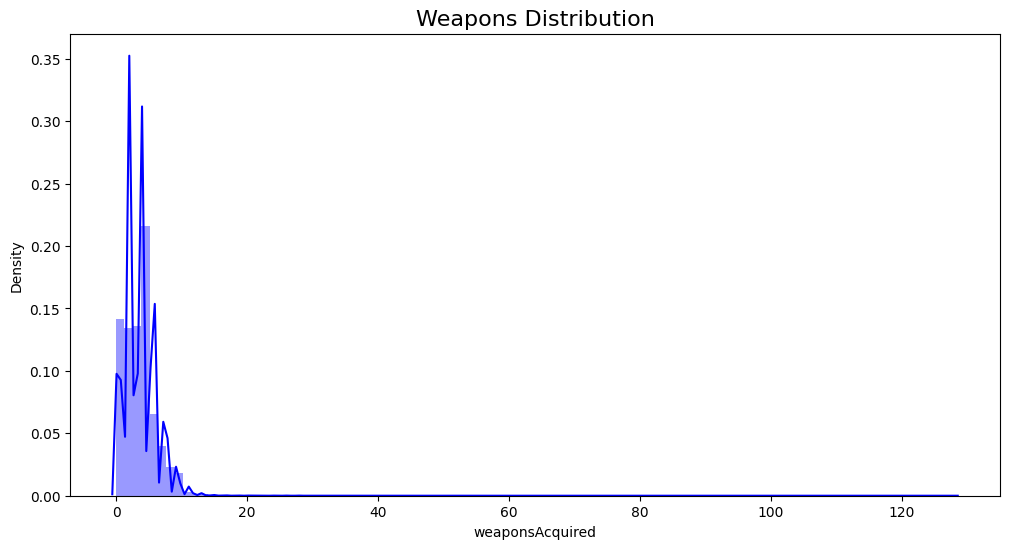

In [30]:
plt.figure(figsize=(12, 6))
sns.distplot(df['weaponsAcquired'], bins=100, kde=True, color='blue')
plt.title('Weapons Distribution', fontsize=16)
plt.show()

In [31]:
df[df['weaponsAcquired']>=15].shape

(453, 33)

In [32]:
df.drop(df[df['weaponsAcquired']>=15].index, inplace = True)

In [33]:
df.isnull().sum()

Id                         0
groupId                    0
matchId                    0
assists                    0
boosts                     0
damageDealt                0
DBNOs                      0
headshotKills              0
heals                      0
killPlace                  0
killPoints                 0
kills                      0
killStreaks                0
longestKill                0
matchDuration              0
matchType                  0
maxPlace                   0
numGroups                  0
rankPoints                 0
revives                    0
rideDistance               0
roadKills                  0
swimDistance               0
teamKills                  0
vehicleDestroys            0
walkDistance               0
weaponsAcquired            0
winPoints                  0
winPlacePerc               0
playersJoined              0
totalDistance              0
killswithoutMoving         0
headshot_rate         176682
dtype: int64

In [34]:
df['headshot_rate'] = df['headshot_rate'].fillna(0)

In [35]:
df.isnull().sum()

Id                    0
groupId               0
matchId               0
assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
winPlacePerc          0
playersJoined         0
totalDistance         0
killswithoutMoving    0
headshot_rate         0
dtype: int64

Correlation between different features

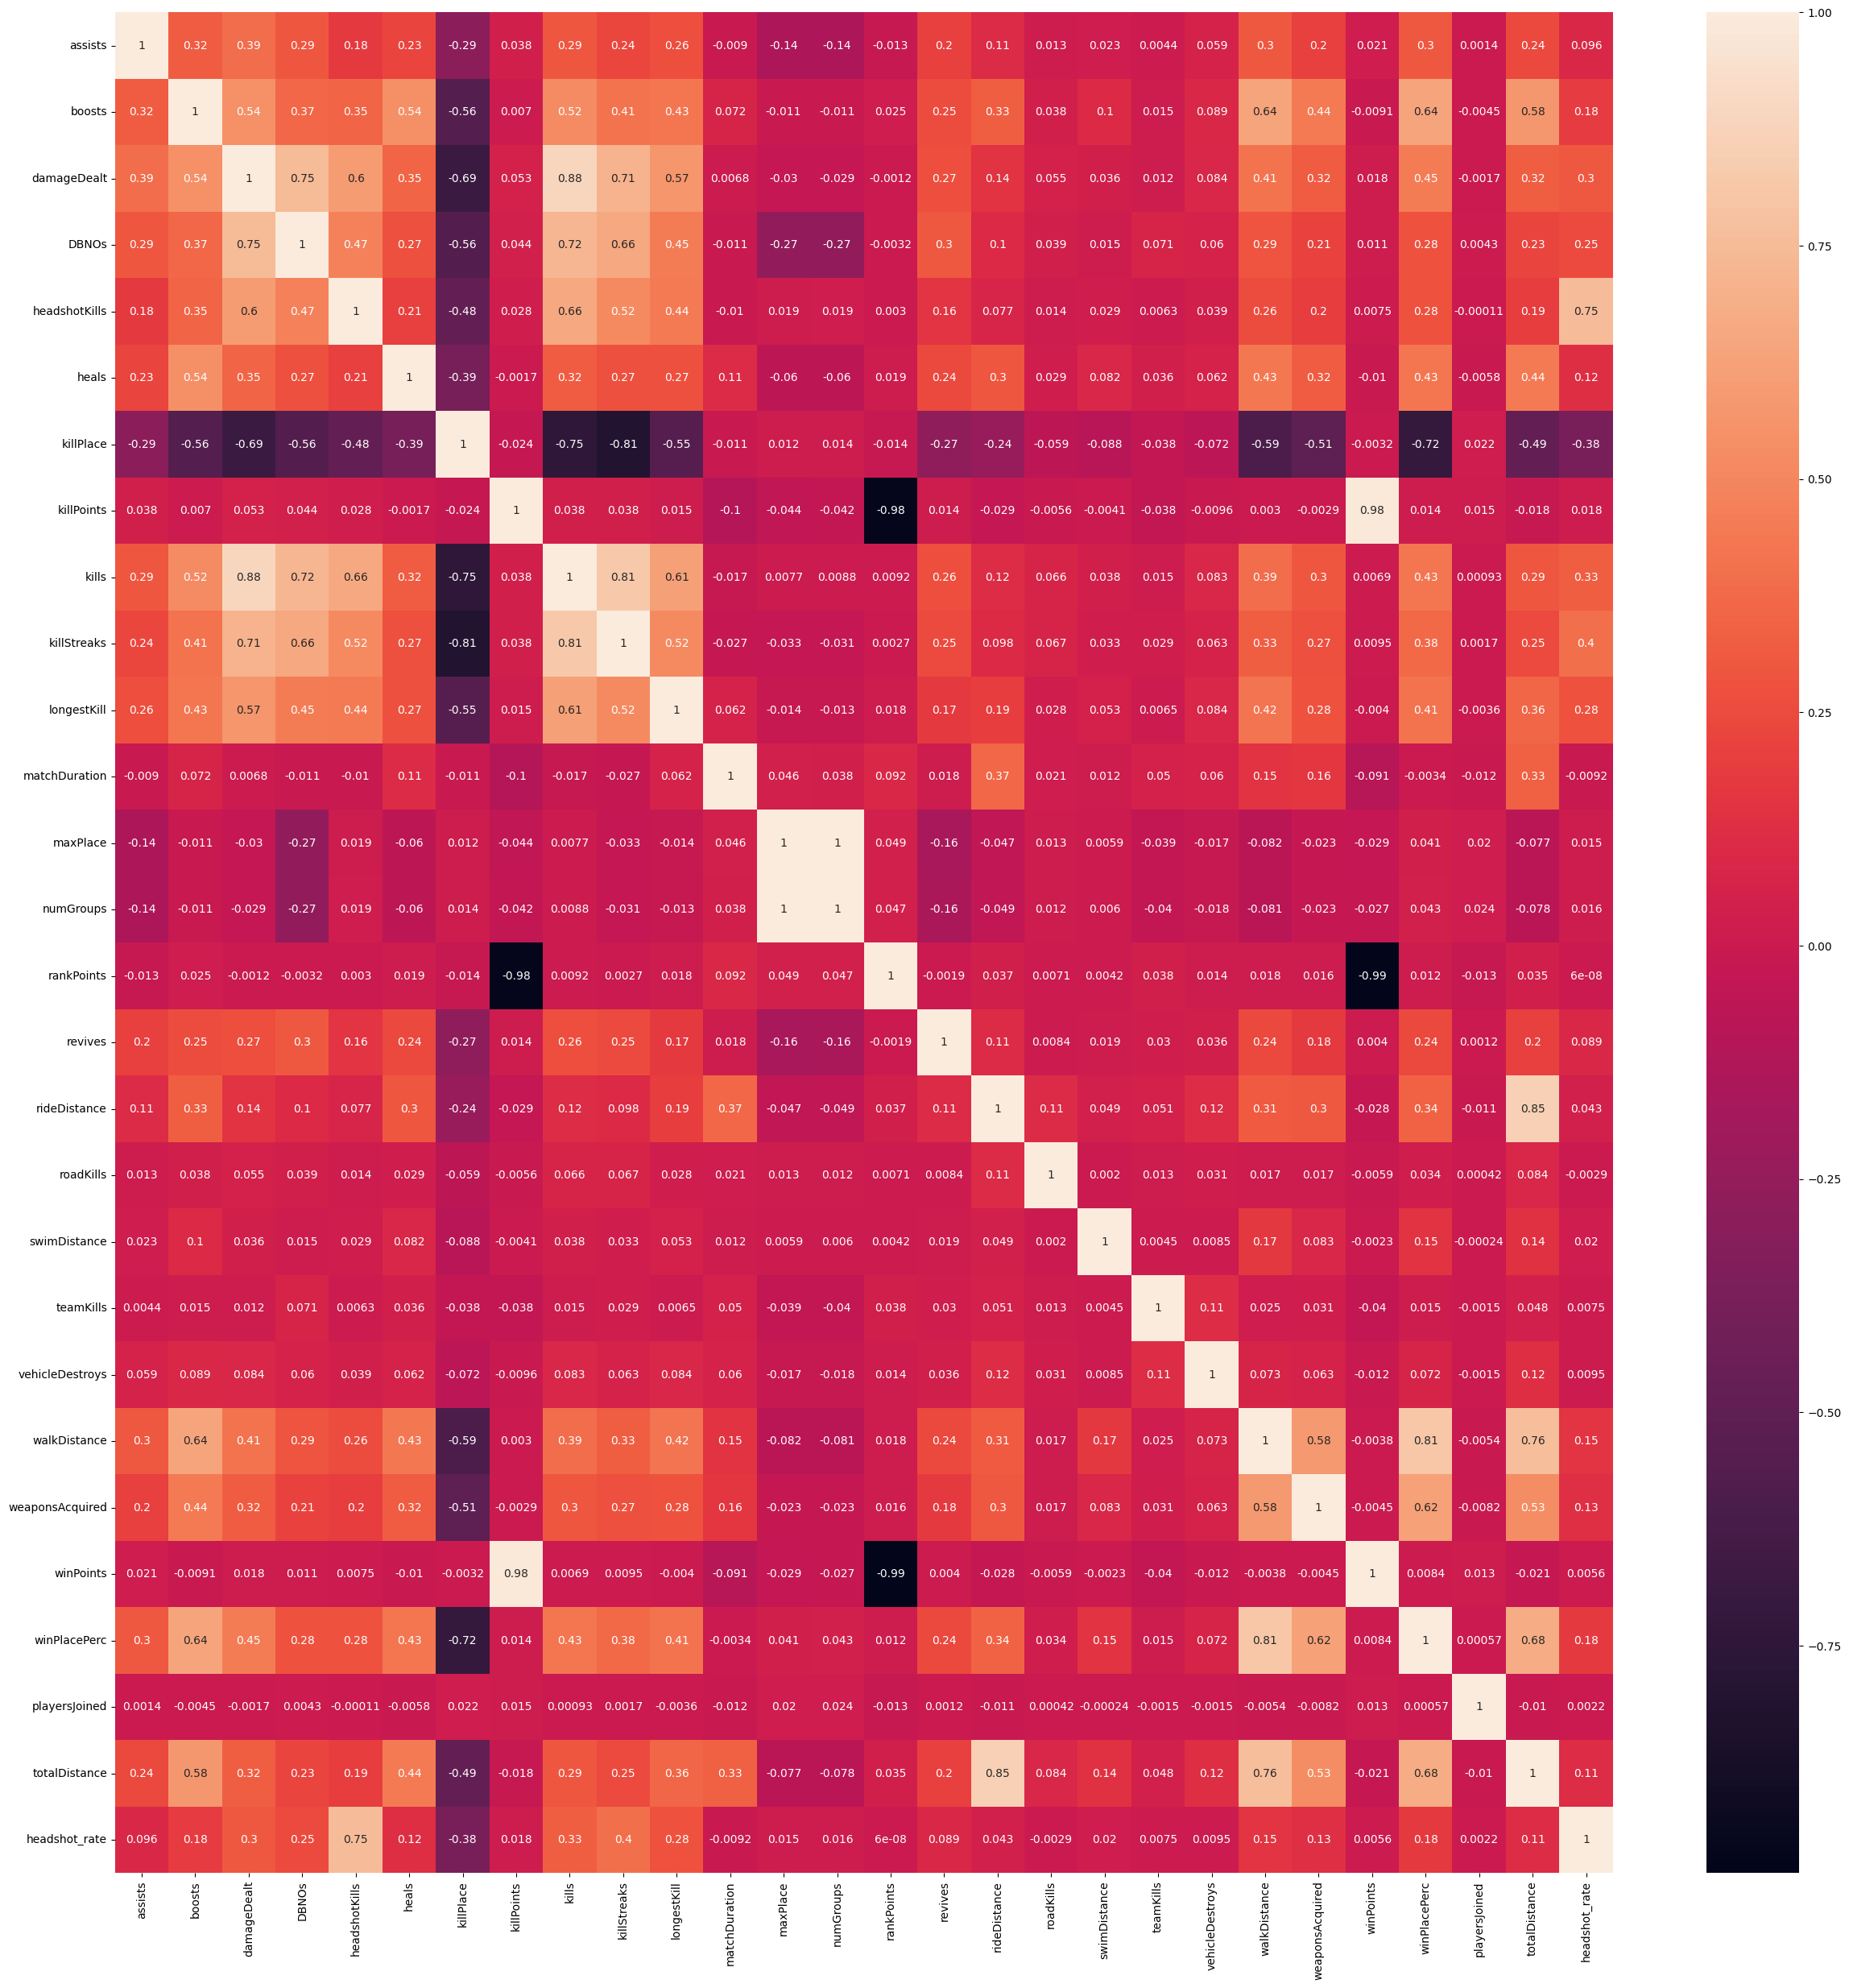

In [36]:
plt.figure(figsize = [30,30])
numeric_df = df.select_dtypes(include=[float, int])
sns.heatmap(numeric_df.corr(), annot=True)
plt.show()

# Feature Engineering

Normalisation of features affected by the number of players joined

In [37]:
normalising_factor = (100 - df['playersJoined']/100) + 1

In [38]:
df['killsNorm'] = df['kills']*normalising_factor
df['damageDealtNorm'] = df['damageDealt']*normalising_factor
df['maxPlaceNorm'] = df['maxPlace']*normalising_factor
df['matchDurationNorm'] = df['matchDuration']*normalising_factor
df['healsnboosts'] = df['heals'] + df['boosts']

In [39]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playersJoined',
       'totalDistance', 'killswithoutMoving', 'headshot_rate', 'killsNorm',
       'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm', 'healsnboosts'],
      dtype='object')

In [40]:
data = df.drop(columns = ['Id','groupId','matchId','boosts','heals','kills','damageDealt','maxPlace','matchDuration','walkDistance','rideDistance','swimDistance'])

In [41]:
data.head()

assists  DBNOs  headshotKills  killPlace  killPoints  killStreaks  \
0        0    0.0            0.0       60.0      1241.0          0.0   
1        0    0.0            0.0       57.0         0.0          0.0   
2        1    0.0            0.0       47.0         0.0          0.0   
3        0    0.0            0.0       75.0         0.0          0.0   
4        0    0.0            0.0       45.0         0.0          1.0   

   longestKill  matchType  numGroups  rankPoints  ...  winPlacePerc  \
0         0.00  squad-fpp       26.0        -1.0  ...        0.4444   
1         0.00  squad-fpp       25.0      1484.0  ...        0.6400   
2         0.00        duo       47.0      1491.0  ...        0.7755   
3         0.00  squad-fpp       30.0      1408.0  ...        0.1667   
4        58.53   solo-fpp       95.0      1560.0  ...        0.1875   

   playersJoined  totalDistance  killswithoutMoving  headshot_rate  killsNorm  \
0              7       244.8000               False            0.0       0.00   
1             12      1445.0445               False            0.0       0.00   
2              9       161.8000               False            0.0       0.00   
3              8       202.7000               False            0.0       0.00   
4              9        49.7500               False            0.0     100.91   

   damageDealtNorm  maxPlaceNorm  matchDurationNorm  healsnboosts  
0           0.0000       2826.04          131814.58           0.0  
1        9227.4936       2622.88          179263.76           0.0  
2        6861.8800       5045.50          132999.38           0.0  
3        3320.2680       3128.52          144921.12           0.0  
4       10091.0000       9788.27          143695.84           0.0  

[5 rows x 26 columns]

# ML

In [42]:
x = data.drop(['winPlacePerc'], axis = 1)
y = data['winPlacePerc']

In [43]:
x = pd.get_dummies(x, columns = ['matchType','killswithoutMoving'])
x = x.astype(int)

In [44]:
features = x.columns

In [45]:
L = x
x.head()

assists  DBNOs  headshotKills  killPlace  killPoints  killStreaks  \
0        0      0              0         60        1241            0   
1        0      0              0         57           0            0   
2        1      0              0         47           0            0   
3        0      0              0         75           0            0   
4        0      0              0         45           0            1   

   longestKill  numGroups  rankPoints  revives  ...  matchType_normal-duo-fpp  \
0            0         26          -1        0  ...                         0   
1            0         25        1484        0  ...                         0   
2            0         47        1491        0  ...                         0   
3            0         30        1408        0  ...                         0   
4           58         95        1560        0  ...                         0   

   matchType_normal-solo  matchType_normal-solo-fpp  matchType_normal-squad  \
0                      0                          0                       0   
1                      0                          0                       0   
2                      0                          0                       0   
3                      0                          0                       0   
4                      0                          0                       0   

   matchType_normal-squad-fpp  matchType_solo  matchType_solo-fpp  \
0                           0               0                   0   
1                           0               0                   0   
2                           0               0                   0   
3                           0               0                   0   
4                           0               0                   1   

   matchType_squad  matchType_squad-fpp  killswithoutMoving_False  
0                0                    1                         1  
1                0                    1                         1  
2                0                    0                         1  
3                0                    1                         1  
4                0                    0                         1  

[5 rows x 40 columns]

Scaling the data

In [46]:
sc = StandardScaler()
x_scaled = sc.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=features)

Splitting data

In [47]:
xtrain, xtest, ytrain, ytest = train_test_split(x_scaled,y, test_size = 0.3, random_state = 0)

CatBoostModel

In [48]:
import catboost as cb
train_dataset = cb.Pool(xtrain, ytrain)
test_dataset = cb.Pool(xtest, ytest)

In [49]:
model = cb.CatBoostRegressor(loss_function = 'RMSE')

In [50]:
grid = {'iterations':[100,150],
       'learning_rate': [0.03,0.1],
       'depth': [2,4,6,8],
       'task_type': ["CPU"]}

model.grid_search(grid,train_dataset)

0:	learn: 0.5483665	test: 0.5491899	best: 0.5491899 (0)	total: 194ms	remaining: 19.2s
1:	learn: 0.5335775	test: 0.5344089	best: 0.5344089 (1)	total: 297ms	remaining: 14.6s
2:	learn: 0.5192722	test: 0.5201022	best: 0.5201022 (2)	total: 380ms	remaining: 12.3s
3:	learn: 0.5053388	test: 0.5061876	best: 0.5061876 (3)	total: 493ms	remaining: 11.8s
4:	learn: 0.4918391	test: 0.4927098	best: 0.4927098 (4)	total: 567ms	remaining: 10.8s
5:	learn: 0.4787927	test: 0.4796749	best: 0.4796749 (5)	total: 660ms	remaining: 10.3s
6:	learn: 0.4661570	test: 0.4670356	best: 0.4670356 (6)	total: 732ms	remaining: 9.72s
7:	learn: 0.4539592	test: 0.4548491	best: 0.4548491 (7)	total: 833ms	remaining: 9.57s
8:	learn: 0.4421485	test: 0.4430527	best: 0.4430527 (8)	total: 891ms	remaining: 9.01s
9:	learn: 0.4308698	test: 0.4317831	best: 0.4317831 (9)	total: 980ms	remaining: 8.82s
10:	learn: 0.4198283	test: 0.4207619	best: 0.4207619 (10)	total: 1.09s	remaining: 8.83s
11:	learn: 0.4091824	test: 0.4101297	best: 0.4101297

{'params': {'task_type': 'CPU',
  'depth': 8,
  'learning_rate': 0.1,
  'iterations': 150},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [51]:
x_scaled = pd.DataFrame(x_scaled, columns=features)

feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = features
feature_importance_df['importance'] = model.feature_importances_

In [52]:
feature_importance_df = feature_importance_df.sort_values(by = ['importance'], ascending = False)
feature_importance_df

features  importance
3                    killPlace   41.564129
16               totalDistance   23.939284
18                   killsNorm    8.548801
5                  killStreaks    6.219847
21           matchDurationNorm    5.347921
7                    numGroups    4.150786
22                healsnboosts    2.076133
20                maxPlaceNorm    1.853943
6                  longestKill    1.423208
1                        DBNOs    1.085791
13             weaponsAcquired    0.979766
0                      assists    0.555105
38         matchType_squad-fpp    0.451144
37             matchType_squad    0.420195
26           matchType_duo-fpp    0.236247
35              matchType_solo    0.170978
8                   rankPoints    0.158717
36          matchType_solo-fpp    0.155726
30    matchType_normal-duo-fpp    0.148518
25               matchType_duo    0.103765
14                   winPoints    0.096644
11                   teamKills    0.058009
19             damageDealtNorm    0.047119
23          matchType_crashfpp    0.047041
9                      revives    0.043968
10                   roadKills    0.043000
15               playersJoined    0.031860
2                headshotKills    0.016532
4                   killPoints    0.014367
32   matchType_normal-solo-fpp    0.006036
34  matchType_normal-squad-fpp    0.005419
12             vehicleDestroys    0.000000
17               headshot_rate    0.000000
31       matchType_normal-solo    0.000000
28          matchType_flaretpp    0.000000
27          matchType_flarefpp    0.000000
24          matchType_crashtpp    0.000000
29        matchType_normal-duo    0.000000
33      matchType_normal-squad    0.000000
39    killswithoutMoving_False    0.000000

In [53]:
pred = model.predict(xtest)

In [62]:
rmse = mean_squared_error(ytest, pred)
r2 = r2_score(ytest, pred)
print(rmse,r2)

0.007311629600928405 0.9227295640559726


Testing other Models

In [83]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


def test_more_models(x_scaled, y):

    xtrain, xtest, ytrain, ytest = train_test_split(x_scaled, y, test_size=0.3, random_state=0)


    models = {
        "RandomForestRegressor": RandomForestRegressor(n_estimators=100, max_depth=8, random_state=0),
        "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0),
        "LinearRegression": LinearRegression(),

    }


    for model_name, model in models.items():
        print({model_name})


        model.fit(xtrain, ytrain)


        pred = model.predict(xtest)
        rmse = mean_squared_error(ytest, pred)
        r2 = r2_score(ytest, pred)

        print(f"{model_name} - RMSE: {rmse:.6f}, R2: {r2:.6f}")


test_more_models(x_scaled, y)



{'RandomForestRegressor'}
RandomForestRegressor - RMSE: 0.011056, R2: 0.883154
{'GradientBoostingRegressor'}
GradientBoostingRegressor - RMSE: 0.007083, R2: 0.925149
{'LinearRegression'}
LinearRegression - RMSE: 0.018732, R2: 0.802038


Testing Catboost model after dropping features having importance less than 0.1

In [80]:
features_to_drop = [
    'matchType_crashfpp',
    'roadKills',
    'revives',
    'killPoints',
    'matchType_normal-squad-fpp',
    'matchType_normal-solo-fpp',
    'headshotKills',
    'vehicleDestroys',
    'headshot_rate',
    'matchType_normal-solo',
    'matchType_flaretpp',
    'matchType_flarefpp',
    'matchType_crashtpp',
    'matchType_normal-duo',
    'matchType_normal-squad',
    'killswithoutMoving_False'
]


x_retrained = L.drop(columns=features_to_drop)


sc = StandardScaler()
x_scaled_retrained = sc.fit_transform(x_retrained)
x_scaled_retrained = pd.DataFrame(x_scaled_retrained, columns=x_retrained.columns)

# Splitting the data
xtrain_retrained, xtest_retrained, ytrain_retrained, ytest_retrained = train_test_split(
    x_scaled_retrained, y, test_size=0.3, random_state=0
)

# Retraining the CatBoost model
train_dataset_retrained = cb.Pool(xtrain_retrained, ytrain_retrained)
test_dataset_retrained = cb.Pool(xtest_retrained, ytest_retrained)

model_retrained = cb.CatBoostRegressor(loss_function='RMSE')
model_retrained.grid_search(grid,train_dataset_retrained)



0:	learn: 0.5483960	test: 0.5492458	best: 0.5492458 (0)	total: 25.9ms	remaining: 2.56s
1:	learn: 0.5335374	test: 0.5343938	best: 0.5343938 (1)	total: 45.3ms	remaining: 2.22s
2:	learn: 0.5191354	test: 0.5200086	best: 0.5200086 (2)	total: 64.9ms	remaining: 2.1s
3:	learn: 0.5051996	test: 0.5060868	best: 0.5060868 (3)	total: 84.6ms	remaining: 2.03s
4:	learn: 0.4917187	test: 0.4926194	best: 0.4926194 (4)	total: 103ms	remaining: 1.95s
5:	learn: 0.4786700	test: 0.4795683	best: 0.4795683 (5)	total: 121ms	remaining: 1.9s
6:	learn: 0.4660654	test: 0.4669716	best: 0.4669716 (6)	total: 142ms	remaining: 1.88s
7:	learn: 0.4538641	test: 0.4547811	best: 0.4547811 (7)	total: 161ms	remaining: 1.84s
8:	learn: 0.4420907	test: 0.4430261	best: 0.4430261 (8)	total: 179ms	remaining: 1.81s
9:	learn: 0.4307003	test: 0.4316465	best: 0.4316465 (9)	total: 199ms	remaining: 1.79s
10:	learn: 0.4196690	test: 0.4206278	best: 0.4206278 (10)	total: 220ms	remaining: 1.78s
11:	learn: 0.4091188	test: 0.4100980	best: 0.41009

{'params': {'task_type': 'CPU',
  'depth': 8,
  'learning_rate': 0.1,
  'iterations': 150},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [81]:
pred_retrained = model_retrained.predict(xtest_retrained)

In [82]:
rmse = mean_squared_error(ytest_retrained, pred_retrained)
r2 = r2_score(ytest_retrained, pred_retrained)
print(rmse, r2)

0.00731424496674024 0.922701924464327


In [84]:
def test_more_models_retrained(x_scaled_retrained, y):

    xtrain_retrained, xtest_retrained, ytrain_retrained, ytest_retrained = train_test_split(x_scaled_retrained, y, test_size=0.3, random_state=0)


    models = {
        "RandomForestRegressor": RandomForestRegressor(n_estimators=100, max_depth=8, random_state=0),
        "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0),
        "LinearRegression": LinearRegression(),

    }


    for model_name, model in models.items():
        print({model_name})


        model.fit(xtrain_retrained, ytrain_retrained)


        pred_retrained = model.predict(xtest_retrained)
        rmse_retrained = mean_squared_error(ytest_retrained, pred_retrained)
        r2_retrained = r2_score(ytest_retrained, pred_retrained)

        print(f"{model_name} - RMSE: {rmse_retrained:.6f}, R2: {r2_retrained:.6f}")


test_more_models_retrained(x_scaled_retrained, y)

{'RandomForestRegressor'}
RandomForestRegressor - RMSE: 0.011055, R2: 0.883169
{'GradientBoostingRegressor'}
GradientBoostingRegressor - RMSE: 0.007072, R2: 0.925262
{'LinearRegression'}
LinearRegression - RMSE: 0.018967, R2: 0.799554
